In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def summarize(alpha=0.05):
    
    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })
    
    return _summarize

In [4]:
wines = pd.read_csv('data/Wines2012.csv', sep=';',
                    names='judge,flight,wine,score,wine_amer,judge_amer'.split(','),
                    skiprows=1)
wines = wines.assign(flight_red = (wines.flight == 'red').astype('int'))
wines = wines.drop(['judge', 'flight', 'wine'], axis=1)
wines.sample(5)

,score,wine_amer,judge_amer,flight_red
173,15.0,1,1,1
147,15.5,1,1,1
42,13.0,0,1,0
139,11.0,0,1,1
113,18.0,1,1,1


In [7]:
train = wines.copy()
test = wines[['wine_amer', 'judge_amer', 'flight_red']].drop_duplicates().reset_index(drop=True)

test

,wine_amer,judge_amer,flight_red
0,1,0,0
1,0,0,0
2,1,1,0
3,0,1,0
4,0,0,1
5,1,0,1
6,0,1,1
7,1,1,1


## univariates

In [8]:
with pm.Model() as model_j:
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=2)

    score = pm.Deterministic(
        'score',
        train.score.mean() + alpha[train.judge_amer.values]
    )

    score_test = pm.Deterministic(
        'score_test',
        train.score.mean()
        + alpha[test.judge_amer.values]
    )

    score_sigma = pm.HalfCauchy('sigma', 10)
    score_obs = pm.Normal('score_obs', mu=score, sd=score_sigma, observed=train.score)

    model_j.name = 'judge'
    model_j.trace = pm.sample(10000, tune=2500, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 25000/25000 [00:14<00:00, 1767.58draws/s]


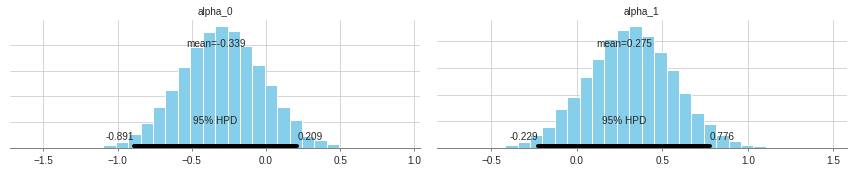

In [9]:
pm.plot_posterior(model_j.trace, varnames=['alpha'])
None

## single interaction, flight vs wine

In [11]:
with pm.Model() as model_fw:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(2, 2))

    score = pm.Deterministic(
        'score',
        train.score.mean()
        + beta[train.wine_amer.values, train.flight_red.values]
    )

    score_test = pm.Deterministic(
        'score_test',
        train.score.mean()
        + beta[test.wine_amer.values, test.flight_red.values]
    )

    score_sigma = pm.HalfCauchy('sigma', 10)
    score_obs = pm.Normal('score_obs', mu=score, sd=score_sigma, observed=train.score)

    model_fw.name = 'wine vs flight'
    model_fw.trace = pm.sample(10000, tune=2500, chains=2)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|██████████| 25000

## interaction + judge

In [12]:
with pm.Model() as model_fw_j:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(2, 2))
    beta_j = pm.Normal('beta_j', mu=0, sd=1, shape=2)

    score = pm.Deterministic(
        'score',
        train.score.mean()
        + beta[train.wine_amer.values, train.flight_red.values]
        + beta_j[train.judge_amer.values]
    )

    score_test = pm.Deterministic(
        'score_test',
        train.score.mean()
        + beta[test.wine_amer.values, test.flight_red.values]
        + beta_j[test.judge_amer.values]
    )
    
    score_sigma = pm.HalfCauchy('sigma', 10)
    score_obs = pm.Normal('score_obs', mu=score, sd=score_sigma, observed=train.score)

    model_fw_j.name = 'wine vs flight & judge'
    model_fw_j.trace = pm.sample(10000, tune=2500, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_j, beta]
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains: 100%|█████████

---

## comparison

In [13]:
comparison = pm.compare({
    model_j: model_j.trace,
    model_fw: model_fw.trace,
    model_fw_j: model_fw_j.trace,
})

comparison

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
wine vs flight & judge,865.26,5.15,0,0.15,17.13,0,0
judge,865.31,2.64,0.05,0.49,17.44,4.06,0
wine vs flight,865.89,4.07,0.63,0.35,16.3,3.18,0


## ensemble model

In [73]:
nsamples = (comparison.weight / comparison.weight.max() * 20000).astype('int')
nsamples.to_frame()

,weight
wine vs flight & judge,6122
judge,20000
wine vs flight,14285


In [80]:
mix = pd.concat([
    pd.DataFrame(model_j.trace['score_test']).sample(nsamples['judge']),
    pd.DataFrame(model_fw.trace['score_test']).sample(nsamples['wine vs flight']),
    pd.DataFrame(model_fw_j.trace['score_test']).sample(nsamples['wine vs flight & judge']),

], ignore_index=True).stack().rename('score_pred').reset_index()

mix = mix.groupby('level_1').score_pred.apply(summarize()).unstack().join(test).sort_values('mean_', ascending=False).reset_index()
mix

,level_1,mean_,lower,upper,wine_amer,judge_amer,flight_red
0,6,14.704271,13.928152,15.576456,0,1,1
1,2,14.428837,13.761338,15.055313,1,1,0
2,3,14.310911,13.470563,15.018175,0,1,0
3,4,14.306782,13.364022,15.446657,0,0,1
4,7,14.144171,13.247386,14.928842,1,1,1
5,0,14.031349,13.321345,14.799743,1,0,0
6,1,13.913422,13.190873,14.709368,0,0,0
7,5,13.746682,13.005943,14.418854,1,0,1


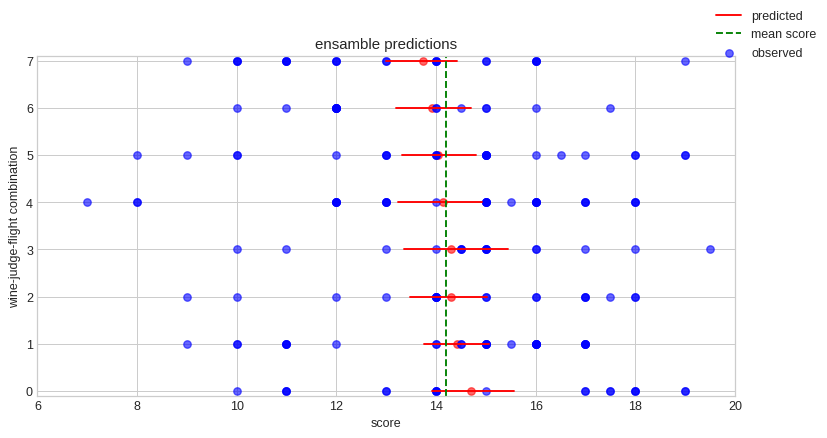

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=90)

ticks, labels = [], []

for ix, row in mix.iterrows():
    pred = ax.plot((row.lower, row.upper), (ix, ix), c='r')
    ax.scatter(row.mean_, ix, c='r', alpha=.6)

    tmp_true = train[(train.wine_amer == row.wine_amer)
                     & (train.judge_amer == row.judge_amer)
                     & (train.flight_red == row.flight_red)]

    obs = ax.scatter(tmp_true.score, np.ones(tmp_true.shape[0]) * ix, c='b', alpha=.6)

ax.axvline(train.score.mean(), label='mean score', c='green', linestyle='--')
    
ax.set(xlabel='score', ylabel='wine-judge-flight combination',
       xlim=(6, 20), title='ensamble predictions', ylim=(-0.1, 7.1))
    
    
obs.set_label('observed')
pred[0].set_label('predicted')

fig.legend()
None